# Intro to working with spectra
### Olivia Cooper
### May 2022

Spectroscopic data is awesome and can give us a ton of info, but it is often more complex to understand and analyze than imaging. The following shows how to examine and work with this type of data. The examples use reduced data taken with MOSFIRE for galaxies at $z\sim2-3$.

In [1]:
# import the basic modules

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import pandas as pd
import astropy
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
plt.style.use('cooper-paper.mplstyle')

### plotting spectra in 1D and 2D

In this example, we'll be looking at a source from a MOSFIRE program called The MOSFIRE Deep Evolution Field Survey (MOSDEF). This data set contains hundreds of galaxies (find the data here: https://mosdef.astro.berkeley.edu/for-scientists/data-releases/), but we'll look at just one.

In [2]:
# load in the spectrum in 1D and 2D for object 2335 in the MOSDEF catalog

hdu2 = fits.open('data/co2_01.H.2335.2d.fits') # 2d spectrum
hdu1 = fits.open('data/co2_01.H.2335.ell.1d.fits') # 1d spectrum

In [3]:
# it's a good idea to check out the header to see how the data are set up

hdu2[0].header

SIMPLE  =                    T / Written by IDL:  Tue Feb 21 13:04:16 2017      
BITPIX  =                    8 / Number of bits per data pixel                  
NAXIS   =                    0 / Number of data axes                            
EXTEND  =                    T / FITS data may contain extensions               
DATE    = '2017-02-21'         / Creation UTC (CCCC-MM-DD) date of FITS header  
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    
COMM1   = 'COMMENT exten 1: science frame (erg/s/cm^2/Angstrom)' /              
COMM2   = 'COMMENT exten 2: weight frame (maximum set to 1)' /                  
COMM3   = 'COMMENT exten 3: noise frame from frame to frame variations' /       
COMM4   = 'COMMENT exten 4: noise frame from subtracted sky' /                  
COMM5   = 'COMMENT exten 5: 1d telluric response spectrum (no units, relative f'
COMM6   = 'COMMENT exten 6: 

Let's first look at the 2D spectrum. Based on the header, we want to look at the science frame, extension 1. (If you want to see the noise frames etc, type in the appropriate index for the extension noted in the header!) I wrote a quick function to help us plot it.

In [4]:
def show_2d(image, lower=-1, upper=2):
    """
    Plot grayscaled 2D spectrum

    Parameters
    ----------
    image : fits data
        Fits data for 2D image.
        
    lower : float
        Lower value to dictate vmin for grayscale. The default is -1.
    
    upper : float
        Upper value to dictate vmax for grayscale. The default is 2.

    Returns
    -------
    Plot of 2D spectrum.

    """

    sample = sigma_clip(image) 
    vmin = sample.mean() + lower * sample.std()
    vmax = sample.mean() + upper * sample.std()
    plt.figure(figsize=(15, 3))
    plt.imshow(image, origin='lower', cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
    plt.xlabel('Column Number')
    plt.ylabel('Row Number')
    plt.grid(False)

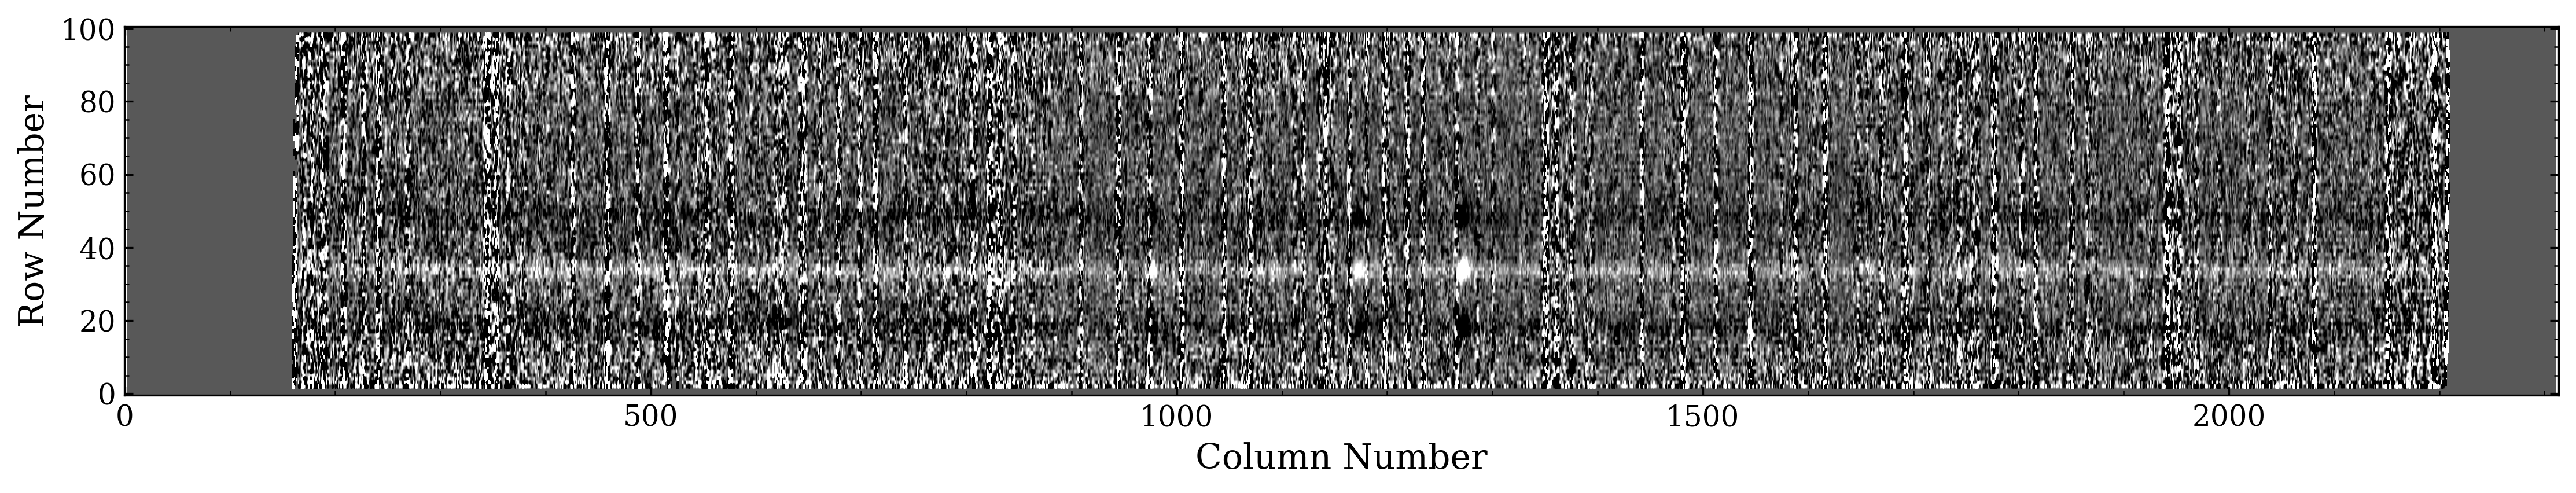

In [5]:
# display the 2D spectrum

show_2d(hdu2[1].data) 

You'll notice a few things: 
1) Going across the image there is a white line -- this is the continuum! That is the signal or light coming from the galaxy, all spread out in wavelength space.

2) Above and below the continuum there are black lines going across. This is the negative of the signal, and is a feature we expect to see in this type of data if the signal is real (it's a product of the ABBA set-up...ask us if you want to know more!).

3) There are TV static noisy vertical features -- these are the residuals of sky lines, of which there are a ton in the near-infrared! These sky lines have to be removed (as they are here) so we can extract the underlying signal from the galaxy.

4) Along the continuum, there are a couple bright spots. Finding and identifying these features is our goal! These are emission lines, and based on the exact positions of these we can measure a spectroscopic redshift :-) More on this later...

The rows and columns are showing the pixel scale, but there is information in the header of the FITS file that tells us how to convert from pixels to wavelength so we can precisely analyze the data. Let's do this with the 1D spectrum...

In [6]:
# check out the header of the 1D spectrum

hdu1[0].header

SIMPLE  =                    T / Written by IDL:  Wed May 10 17:46:48 2017      
BITPIX  =                    8 / Number of bits per data pixel                  
NAXIS   =                    0 / Number of data axes                            
EXTEND  =                    T / FITS data may contain extensions               
DATE    = '2013-08-05'         / Creation UTC (CCCC-MM-DD) date of FITS header  
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    
COMMENT  Exten 1: Optimal extraction                                            
COMMENT  Exten 2: Optimal extraction error bars                                 
COMMENT  Exten 3: Boxcar extraction                                             
COMMENT  Exten 4: Boxcar extraction error bars                                  
COMMENT  Exten 5: Light profile                                                 
COMMENT  Anything called a "

That's a lot of info! Take a gander and see what you can find. (Remind us to talk about optimal vs boxcar extraction sometime if we haven't already) 

Of interest to us at the moment is our wavelength scaling info. First, I'll demo how to make a wavelength array based on the header info.

In [7]:
# translate the header data into a wavelength array

ext = 1 # for the optimal extraction option
im1d = hdu1[ext] # point to the extension we want
wavelength_start = im1d.header['CRVAL1'] # starting wavelength at first pixel
wavelength_logdisp = im1d.header['CDELT1'] # delta wavelength per pixel
num_wavelength = im1d.header['NAXIS1'] # length of data array

wavelength = wavelength_start + np.arange(0, wavelength_logdisp*num_wavelength, wavelength_logdisp) # wavelength
spec1d = im1d.data # spectrum

Great! Now we have the data for the x-axis (wavelength) and for the y-axis (spectrum). Let's plot!

Text(0, 0.5, 'Signal [$erg\\, s^{-1}\\, cm^{-2}\\, \\AA^{-1}$]')

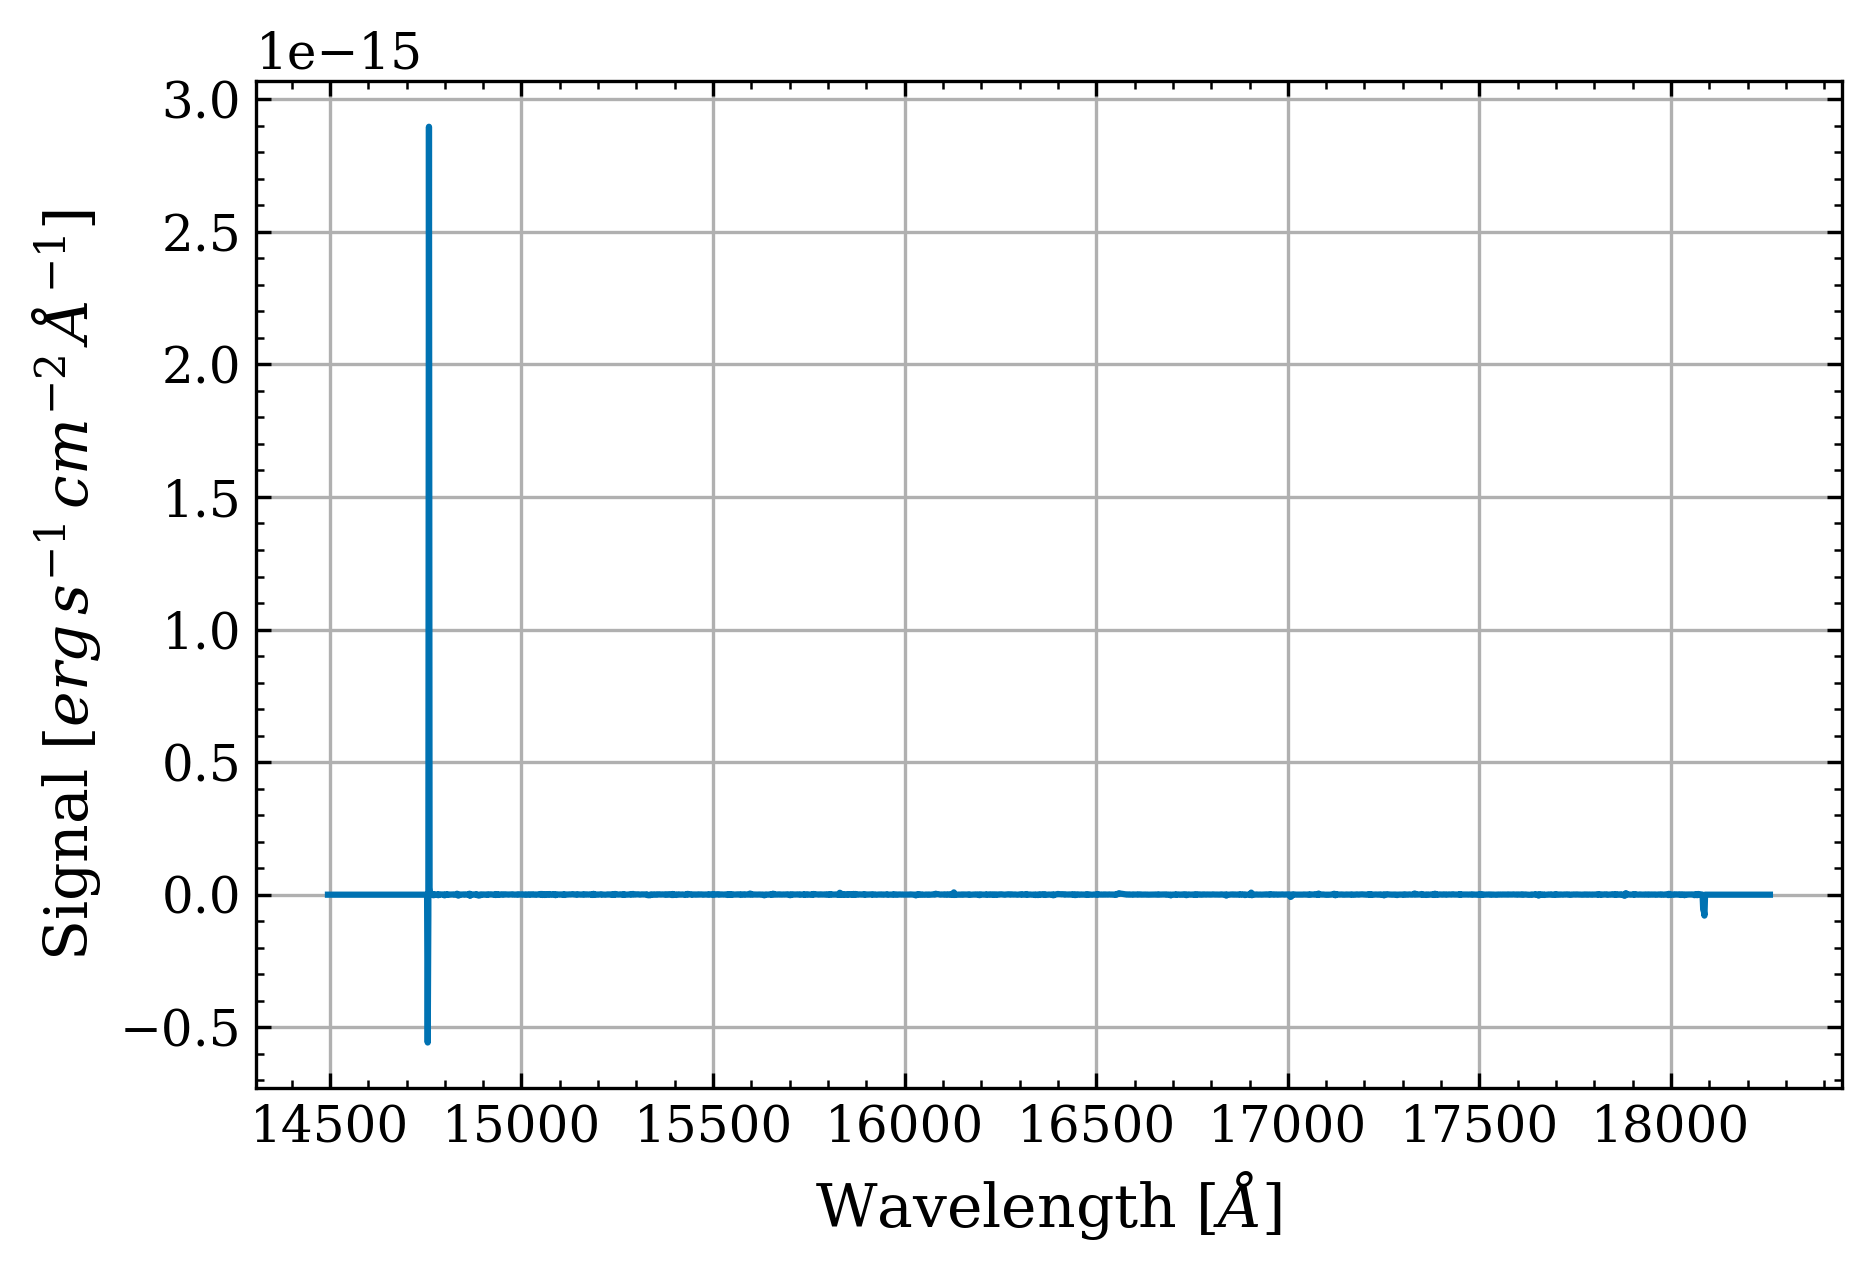

In [8]:
# plot the 1D spectrum

plt.plot(wavelength, spec1d)
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Signal [$erg\, s^{-1}\, cm^{-2}\, \AA^{-1}$]')

Uh...what does it mean? Basically, however `matplotlib` has scaled this data is terrible. But that's fair, because spectra have huge noise spikes that we don't care about. So, we gotta scale better!

(-1e-17, 1e-17)

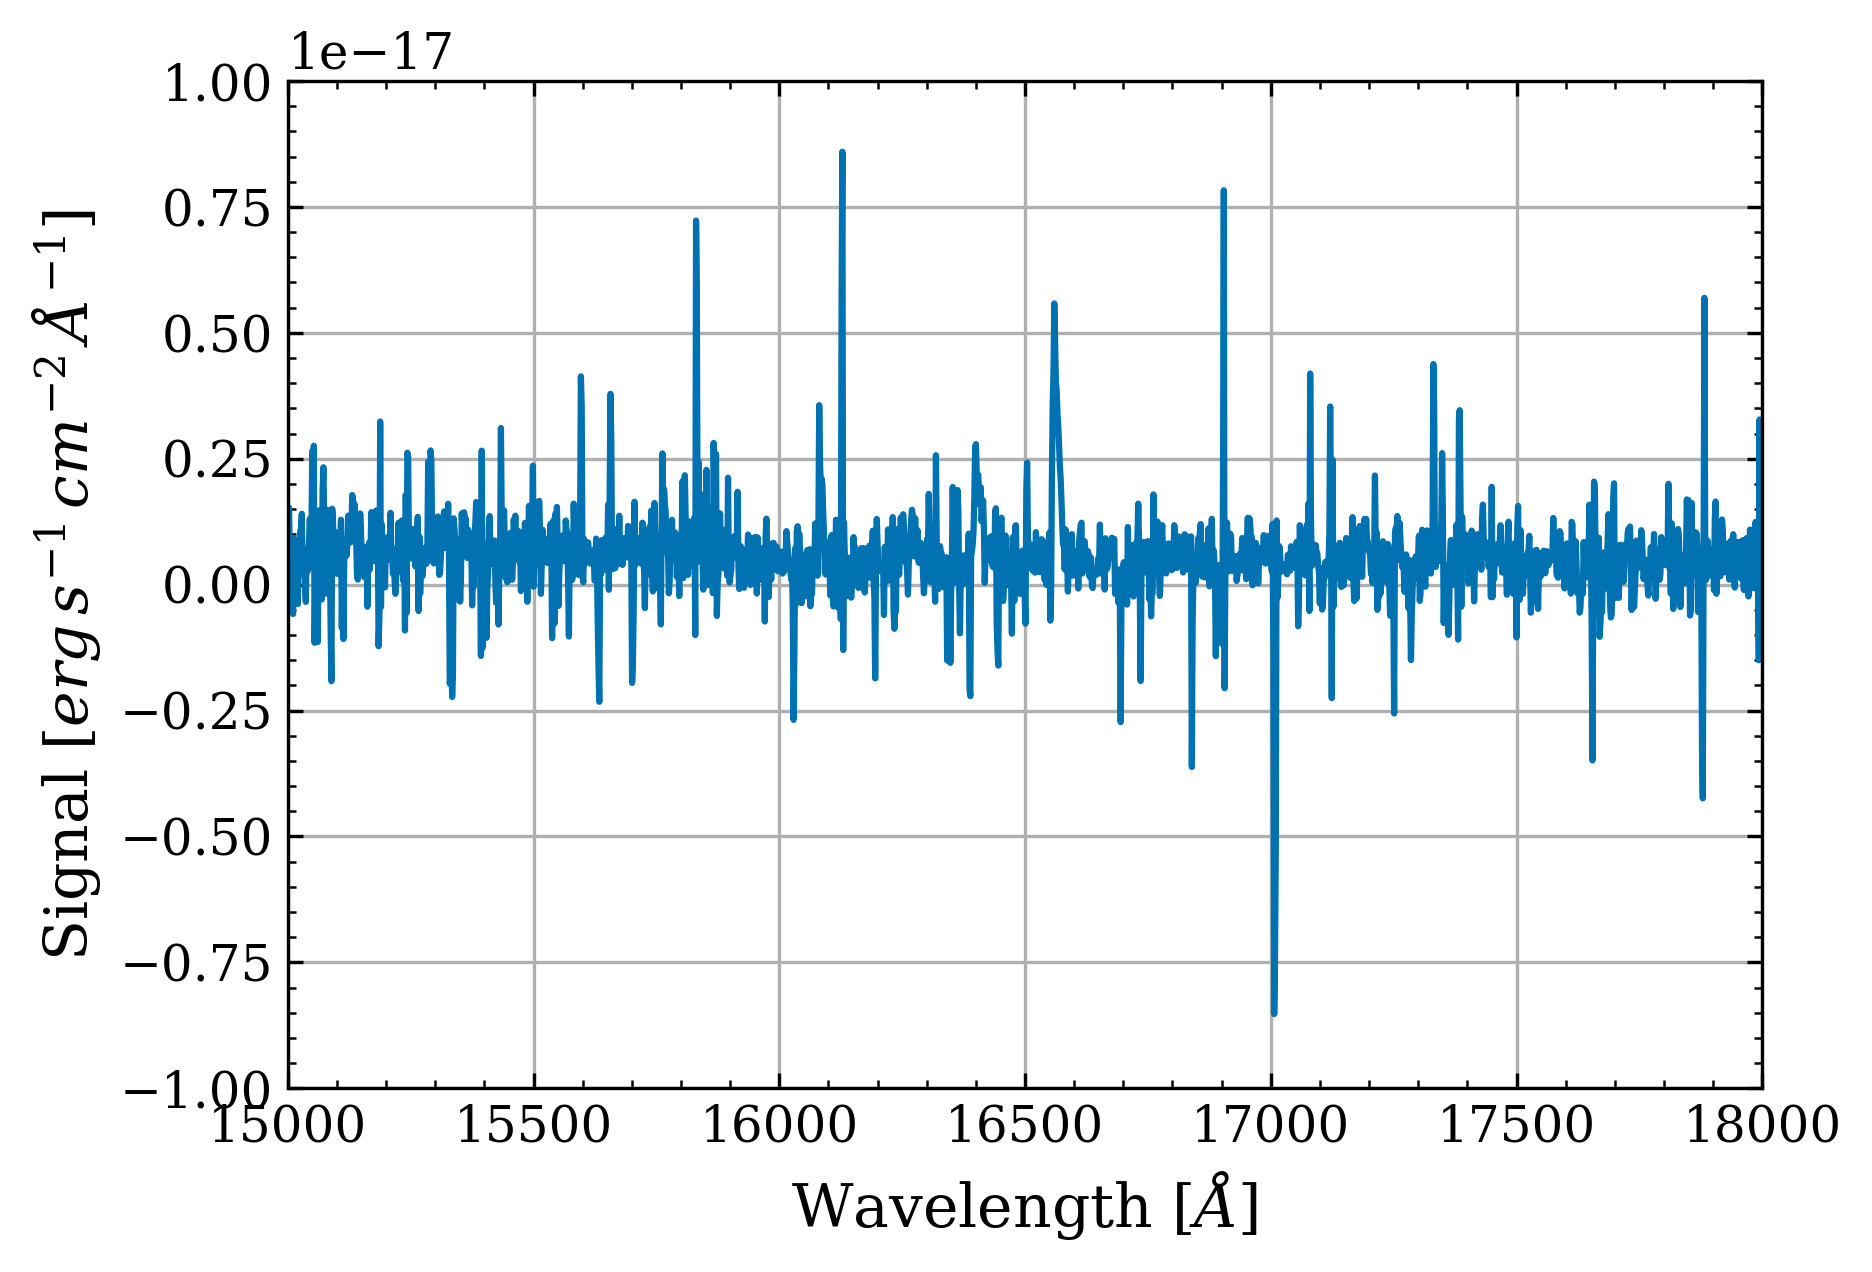

In [9]:
# plot the 1D spectrum, now with a better scale
### note, another way to do this is to multiply the signal by a factor
### here I would use 1e17 and then set ylim from -1 to 1

plt.plot(wavelength, spec1d)
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Signal [$erg\, s^{-1}\, cm^{-2}\, \AA^{-1}$]')

plt.xlim(15000,18000)
plt.ylim(-1e-17,1e-17)

There's our signal!! And you may start to notice some features...it'll get easier with practice looking at spectroscopic data. And using the 1D and 2D together is essential to pick out the features in 1D!

### fitting a redshift

Our next task is to figure out what lines we're seeing. Load in the provided line list and let's see if we can figure it out...

In [10]:
# list of spectral lines (originally from SDSS)
### shows the vacuum (rest) wavelength, the species, and the type of line

lines = pd.read_csv('linelist.csv',delimiter=",",comment='#') # all lines
em = lines[lines['type']=='Emission'] # emission lines
ab = lines[lines['type']=='Absorption'] # absorption lines
sky = lines[lines['type']=='Sky'] # absorption lines

em

lambda    species      type
0   1033.820        OVI  Emission
1   1215.240   Ly alpha  Emission
2   1240.810         NV  Emission
3   1305.530         OI  Emission
4   1335.310        CII  Emission
5   1397.610       SiIV  Emission
6   1399.800  SiIV+ OIV  Emission
7   1549.480        CIV  Emission
8   1640.400       HeII  Emission
9   1665.850       OIII  Emission
10  1857.400      AlIII  Emission
11  1908.734       CIII  Emission
12  2326.000        CII  Emission
13  2439.500       NeIV  Emission
14  2799.120       MgII  Emission
15  3346.790        NeV  Emission
16  3426.850       NeVI  Emission
17  3727.090        OII  Emission
18  3729.880        OII  Emission
19  3889.000        HeI  Emission
20  4072.300        SII  Emission
21  4102.890    H delta  Emission
22  4341.680    H gamma  Emission
23  4364.440       OIII  Emission
24  4862.680     H beta  Emission
25  4932.600       OIII  Emission
26  4960.300       OIII  Emission
27  5008.240       OIII  Emission
28  6302.050         OI  Emission
29  6365.540         OI  Emission
30  6529.030         NI  Emission
31  6549.860        NII  Emission
32  6564.610    H alpha  Emission
33  6585.270        NII  Emission
34  6718.290        SII  Emission
35  6732.670        SII  Emission

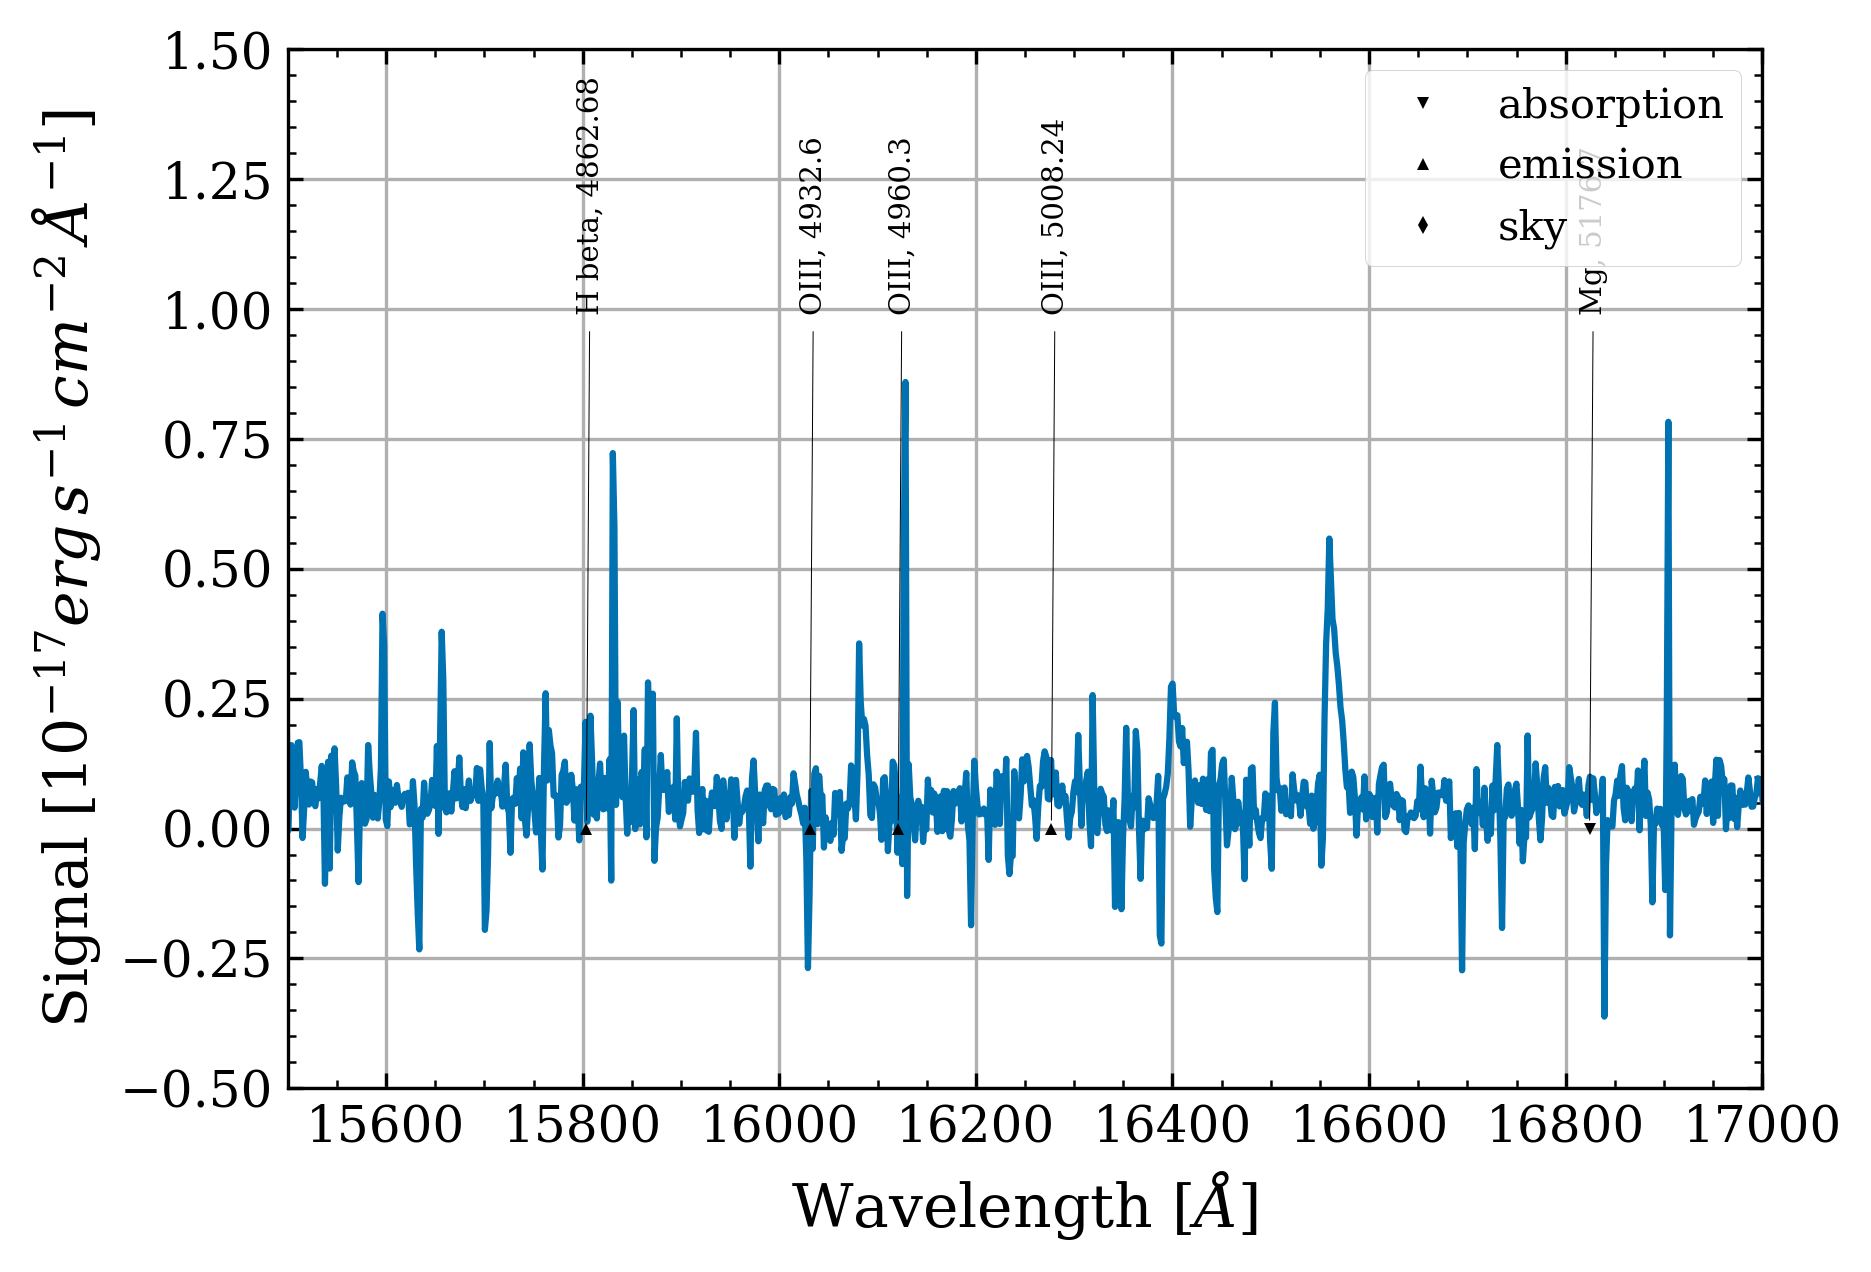

In [11]:
# pay attention to the scaling here!
# your task: change zguess until the lines match up with the features :-) 

zguess = 2.25 ## adjust the redshift!

plt.plot(wavelength, spec1d*1e17)
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Signal [$10^{-17} erg\, s^{-1}\, cm^{-2}\, \AA^{-1}$]')

plt.xlim(15500,17000)
plt.ylim(-0.5,1.5)

plt.plot(ab['lambda']*(1+zguess),0*np.ones_like(ab['lambda']),'kv',ms=3,label='absorption')
plt.plot(em['lambda']*(1+zguess),0*np.ones_like(em['lambda']),'k^',ms=3,label='emission')
plt.plot(sky['lambda']*(1+zguess),0*np.ones_like(sky['lambda']),'kd',ms=3,label='sky')

for i in range(len(lines['lambda'])):
    plt.annotate(str(lines['species'][i]+', '+str(lines['lambda'][i])),xy=(lines['lambda'][i]*(1+zguess), 0),\
                xytext=(lines['lambda'][i]*(1+zguess)-10, 1),arrowprops=dict(arrowstyle="-",),size=7,rotation=90)
plt.legend()

From the catalog, the measured redshift of the object is $z = 2.3074$. Do you agree? Let's confirm by fitting a Gaussian to a line.

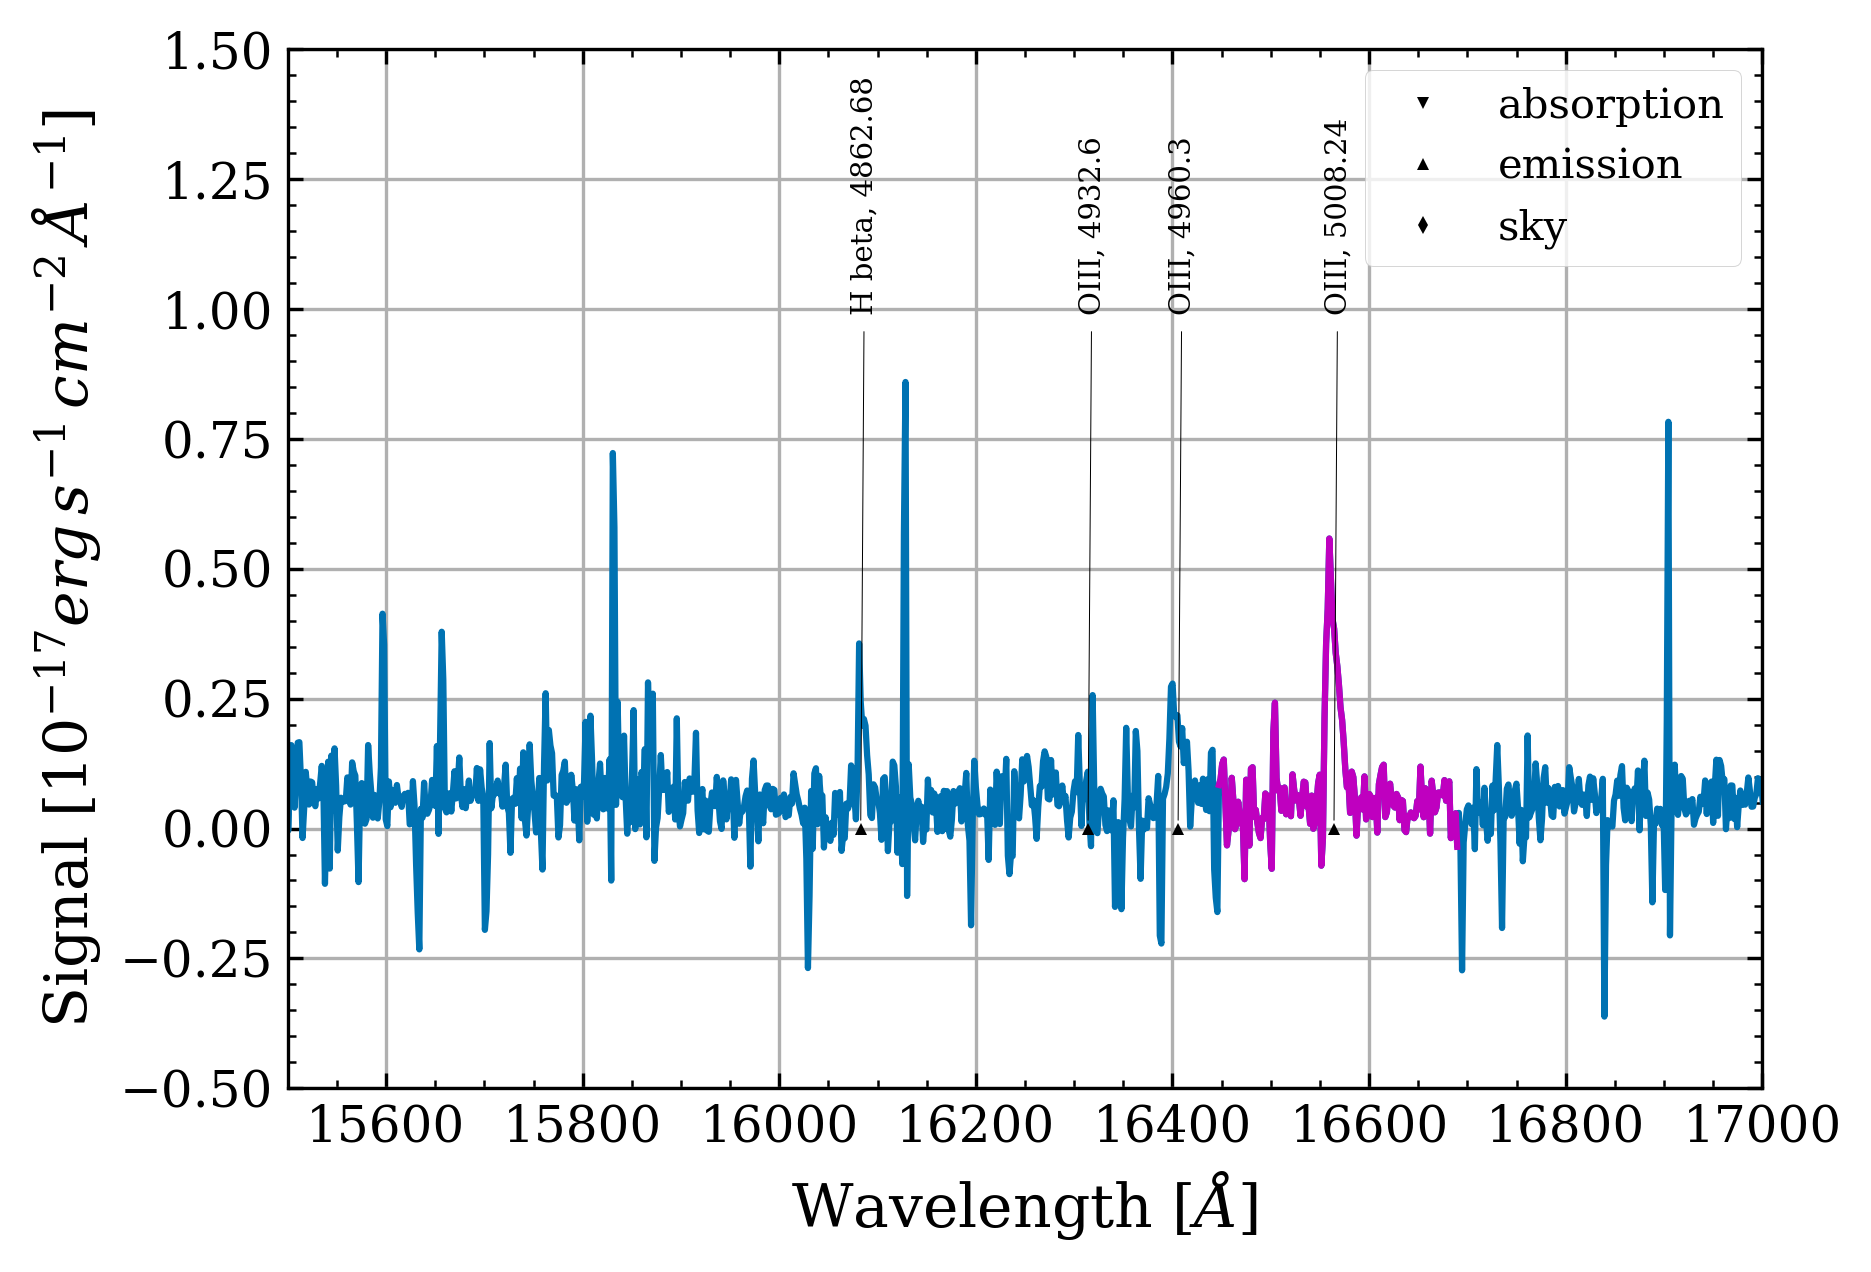

In [12]:
# let's fit the 5008 OII line, highlighted!

zguess = 2.3074 

plt.plot(wavelength, spec1d*1e17)
plt.plot(wavelength[1200:1350],spec1d[1200:1350]*1e17, 'm')
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Signal [$10^{-17} erg\, s^{-1}\, cm^{-2}\, \AA^{-1}$]')

plt.xlim(15500,17000)
plt.ylim(-0.5,1.5)

plt.plot(ab['lambda']*(1+zguess),0*np.ones_like(ab['lambda']),'kv',ms=3,label='absorption')
plt.plot(em['lambda']*(1+zguess),0*np.ones_like(em['lambda']),'k^',ms=3,label='emission')
plt.plot(sky['lambda']*(1+zguess),0*np.ones_like(sky['lambda']),'kd',ms=3,label='sky')

for i in range(len(lines['lambda'])):
    plt.annotate(str(lines['species'][i]+', '+str(lines['lambda'][i])),xy=(lines['lambda'][i]*(1+zguess), 0),\
                xytext=(lines['lambda'][i]*(1+zguess)-10, 1),arrowprops=dict(arrowstyle="-",),size=7,rotation=90)
plt.legend()

In [13]:
# gaussian function to model spectral lines

def gaussian(x, *params):
    amp, x0, sigma = params
    return amp * np.exp(-(x - x0)**2 / 2 / sigma**2)

In [14]:
# fit a gaussian to find line center
# make a cut so the fit only uses data around the line we want to fit

wav = wavelength[1200:1350]
spec = spec1d[1200:1350]

guess = 6000, 5008*(1+zguess), 2.5
bounds = ((0, 5008*(1+zguess) - 25, 0), (np.inf, 5008*(1+zguess) + 25, np.inf))
popt, pcov = curve_fit(gaussian, wav, spec, p0=guess, bounds=bounds)

obswav = popt[1]
obswav_error = np.sqrt(pcov[1, 1])
print(f'Observed wavelength of OII [5008] is {obswav:.3f} +/- {obswav_error:.3f}')

Observed wavelength of OII [5008] is 16563.603 +/- 0.002


In [15]:
# measure the redshift

restwav = 5008
redshift = obswav / restwav - 1
print(f'The redshift is {redshift:.4f} ')

The redshift is 2.3074 


Looks like we get the same answer as the astronomers of [Kriek et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJS..218...15K/abstract)!! Yeehaw :-)